# Example 12-5: Shooting method

In this final example, we're going to move away from direct methods and discuss a different class of algorithms known as the **shooting method**.
Now we might know our target value (e.g., if we're launching a projectile), but for some reason our ODE system is underspecified.
Therefore, we have to make **iterative guesses** at our boundary conditions and check to see how close we get.

## Summary of commands

- We'll be using the `break` keyword to exit the loop when our tolerance is reached.
  See the course notes for the theory behind the shooting method.
- Otherwise, we'll be using a lot of the same machinery as previous examples.

## Modeling chemical pollution

Consider a river being polluted by a chemical plant. 
The river flow has a velocity $V$ in the $x$-direction. 
Chemical plants along the river release toxic waste into it, modeled by the function $S(x)$. 
Given that the diffusion coefficient of the toxic waste in water is $D$, the equation governing the distribution of waste along the river is the convection diffusion equation:

$$ V \frac{dy}{dx} - D \frac{d^2y}{dx^2} = S(x) $$

where $y(x)$ is the concentration of the toxic waste in the river. 
The domain is non-dimensionalized so that the total river section under consideration is $1$, i.e., $x = [0, 1]$, with $x = 0$ corresponding to a point upstream of the chemical plant and $x = 1$ a point downstream. 
We are asked to solve for $y(x)$ given the following information:

$$ V = 1.0, \quad D = 0.1, \quad S(x) = 0.1 \exp \left[ -100 (x - 0.5)^2 \right] $$ 

and the boundary conditions

$$ y(x = 0) = 0,\ \quad \frac{dy}{dx} \bigg|_{x=1} = 0 $$

We convert this 2nd-order ODE to a system of 2 first-order ODEs with $y_1(x) = y(x)$ and $y_2(x) = y'(x)$.
This gives us

$$ \begin{align}
y_1' &= y_2 \\
y_2' &= \frac{V}{D} y_2 - \frac{0.1}{D} \exp \left[-100(x  -0.5)^2 \right]
\end{align} $$

with boundary conditions

$$ y_1(0) = 0,\ \quad y_2(1) = 0 $$

Iteration     y''(0)      y''(1)   
0         0.00000000  -33.776992
1         0.00500000   76.355337
2         0.00153347    0.000000



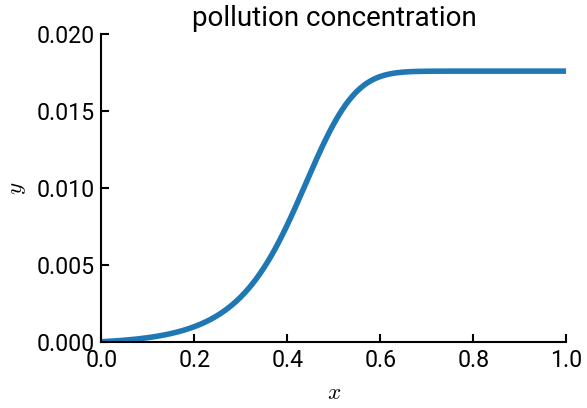

In [2]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

# user-defined function
def pollution(x, y, A1, A2):
    S = 0.1 * np.exp(-100 * (x - 0.5)**2)
    return np.array([y[1], A1/A2 * y[1] - S/A2])

# 4th-order Runge-Kutta
def RK4(f, t0, tf, y0, h, args):
    t = np.arange(t0, tf+h, h)
    y = np.zeros((len(t), len(y0)))
    y[0, :] = y0
    for n in range(len(t) - 1):
        k1 = f(t[n], y[n, :], *args)
        k2 = f(t[n] + 0.5 * h, y[n, :] + 0.5 * h * k1, *args)
        k3 = f(t[n] + 0.5 * h, y[n, :] + 0.5 * h * k2, *args)
        k4 = f(t[n] + h, y[n, :] + h * k3, *args)
        y[n+1, :] = y[n, :] + 1/6 * h * (k1 + 2 * k2 + 2 * k3 + k4)
    return t, y

# constants
V = 1
D = 0.1
xL = 0
xR = 1
y0 = 0
yp1 = 0
target = yp1 

# initial guess
guess = [0.0, 0.005]
tol = 1e-5 
N = 1025
h = (xR - xL) / (N - 1)

print("Iteration     y''(0)      y''(1)   ")
result = []
for k in range(15):
    x, y = RK4(pollution, xL, xR, [y0, guess[k]], h, [V, D])   # solve for current guess
    result.append(y[-1, 1])                                    # store the result
    print(f"{k} {guess[k]:18.8f} {result[k]:11.6f}")

    if k > 0:
        if abs(result[k] - target) > tol:        # check for convergence
            slope = (guess[k] - guess[k-1]) / (result[k] - result[k-1])
            guess.append(guess[k-1] + slope * (target - result[k-1]))  # next guess
        else:
            break      # tolerance is reached, exit loop

# plot the results
fig, ax = plt.subplots()
ax.plot(x, y[:, 0], label='numerical')
ax.set(xlabel="$x$", ylabel="$y$", xlim=[0,1], ylim=[0, 0.02], 
       title="pollution concentration")
plt.show()